In [43]:
import altair as alt
import pandas as pd
import numpy as np

In [60]:
# Moved data to a gist so schema can be reused 

# data = pd.read_csv('Refinery_Site_Stats.csv').drop('ID', axis=1).drop([0])
# data.columns = data.columns.str.replace(' ', '_')
# data['run_date'] = pd.to_datetime(data['run_date']).dt.normalize()
# data.head()

In [75]:
# add API endpoint here
url = "https://gist.githubusercontent.com/manzt/abbf9a798982d7da7150cc412a8ffe69/raw/73a63f1179a5abeeb70446911d1ac033ab9af5c9/refinery-usage.csv"

data = alt.UrlData(url)

# define columns at endpoint as below, and normalize the time of each entry
columns = [
    "datasets_shared",
    "datasets_uploaded",
    "groups_created",
    "total_user_logins",
    "total_visualization_launches",
    "total_workflow_launches",
    "users_created",
    "unique_user_logins",
]

In [76]:
# Define altair selections, brushing for overview and single selection for coordinated views
brush = alt.selection_interval(encodings=['x'])
nearest = alt.selection_single(nearest=True, on='mouseover', encodings=['x'], empty='none')

# Define x encoding for all charts as time 
base = alt.Chart(data).encode(
    alt.X('run_date:T', title=None)
)

# Define hidden encoding (opacity == 0) to track selections
selectors = base.mark_point().encode(
    opacity=alt.value(0),
).properties(
    selection=nearest # add single selection
).transform_filter(
    brush # apply filtering selection
)

# filter rules on panels by both selection and timeline
rules = base.mark_rule(color='gray').transform_filter(
    nearest 
).transform_filter(
    brush
)

In [77]:
def create_panel(colname, w, h):
    """Create layered panel for multi-coordinated view chart.

    @param: colname - Name of field for Y encoding.
    @param: w - width of panel in px.
    @param: h - height of panel in px.

    """
    
    # Create main line encoding and apply brush filtering
    line = base.mark_line(interpolate='step-before').encode(
        alt.Y(colname + ':Q', title=None),
    ).transform_filter(
        brush
    )
    
    # Add hidden points that will reveal on selection
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )
    
    # Add hidden text that will reveal on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, colname + ':Q', alt.value(' '))
    ) 
    
    # Layer the charts together for a single panel
    panel = alt.layer(line, selectors, points, rules, text, width=w, height=h, title=colname.replace('_', ' '))
    
    return panel

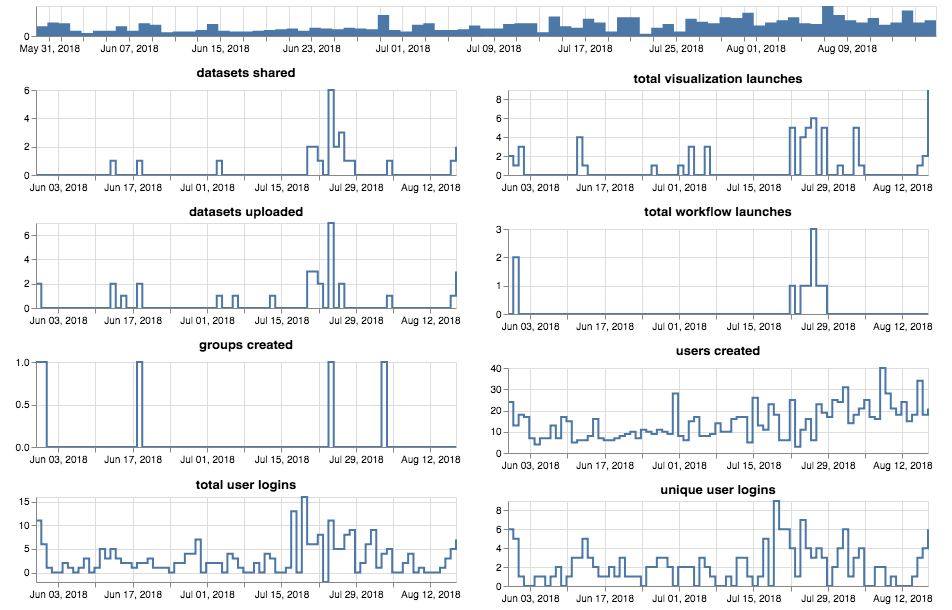

In [78]:
# Create panel for each column name
panels = [create_panel(colname, 420, 85) for colname in columns]

# Create over
timeline = base.mark_area(interpolate='step-after').encode(
    alt.Y('users_created:Q', title=None)
).properties(
    width=900,
    height=30,
    selection=brush
)

chart = timeline & (alt.vconcat(*panels[:4]) | alt.vconcat(*panels[4:]))

chart

In [79]:
# save Vega-Lite schema
chart.save('chart.json')